# 3.3.1

C:\Users\marti\AppData\Local\Temp\ipykernel_35596\2208751284.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv("fused_edges.csv")
C:\Users\marti\AppData\Local\Temp\ipykernel_35596\2208751284.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


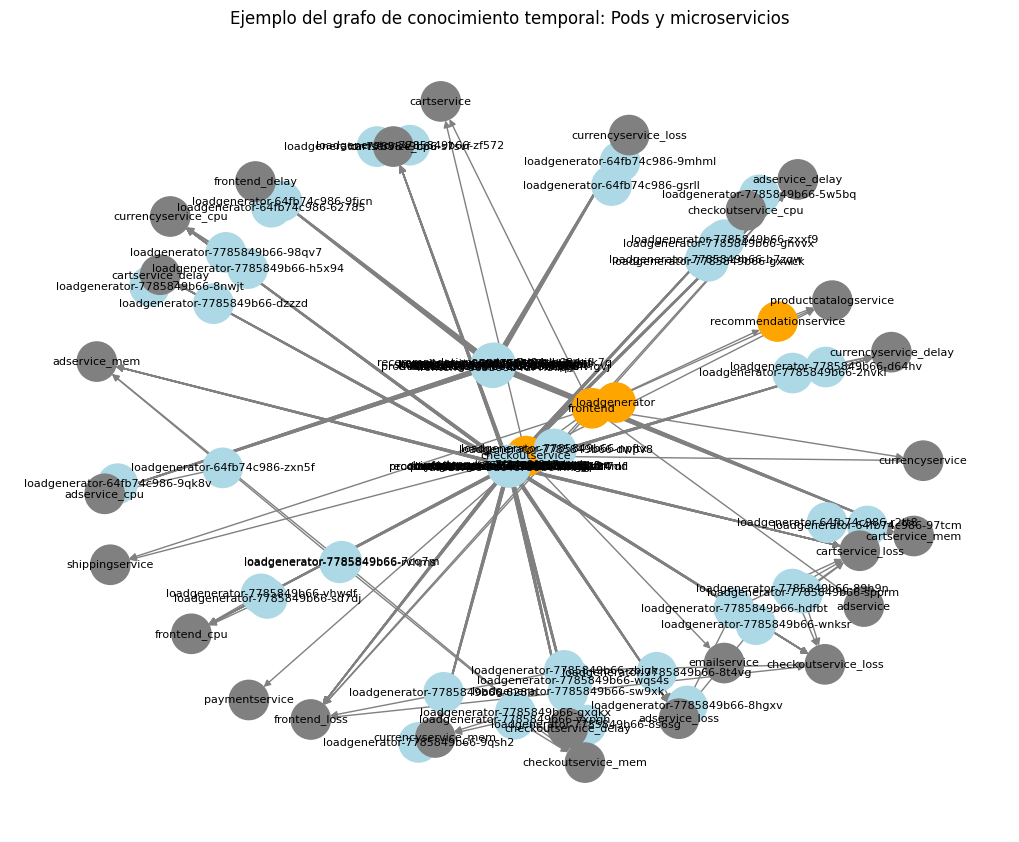

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Cargar los nodos y enlaces desde los CSV ya generados
nodes_df = pd.read_csv("fused_nodes.csv")
edges_df = pd.read_csv("fused_edges.csv")

# Crear grafo dirigido
G = nx.DiGraph()

# Añadir nodos con tipo
for _, row in nodes_df.iterrows():
    G.add_node(row["id"], tipo=row["layer"] if "layer" in row and pd.notnull(row["layer"]) else "Unknown")

# Añadir aristas
for _, row in edges_df.iterrows():
    G.add_edge(row["src"], row["dst"])

# Colores por tipo de nodo
color_map = []
for node in G.nodes(data=True):
    tipo = node[1].get('tipo', 'Unknown')  # Use 'Unknown' as the default value if 'tipo' is missing
    if tipo == 'Pod':
        color_map.append('lightblue')
    elif tipo == 'Microservice':
        color_map.append('orange')
    else:
        color_map.append('grey')

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=800, edge_color="gray", font_size=8)
plt.title("Ejemplo del grafo de conocimiento temporal: Pods y microservicios")
plt.tight_layout()
plt.savefig("grafo_entidades_relaciones.png", dpi=300)
plt.show()


C:\Users\marti\AppData\Local\Temp\ipykernel_35596\2005114789.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


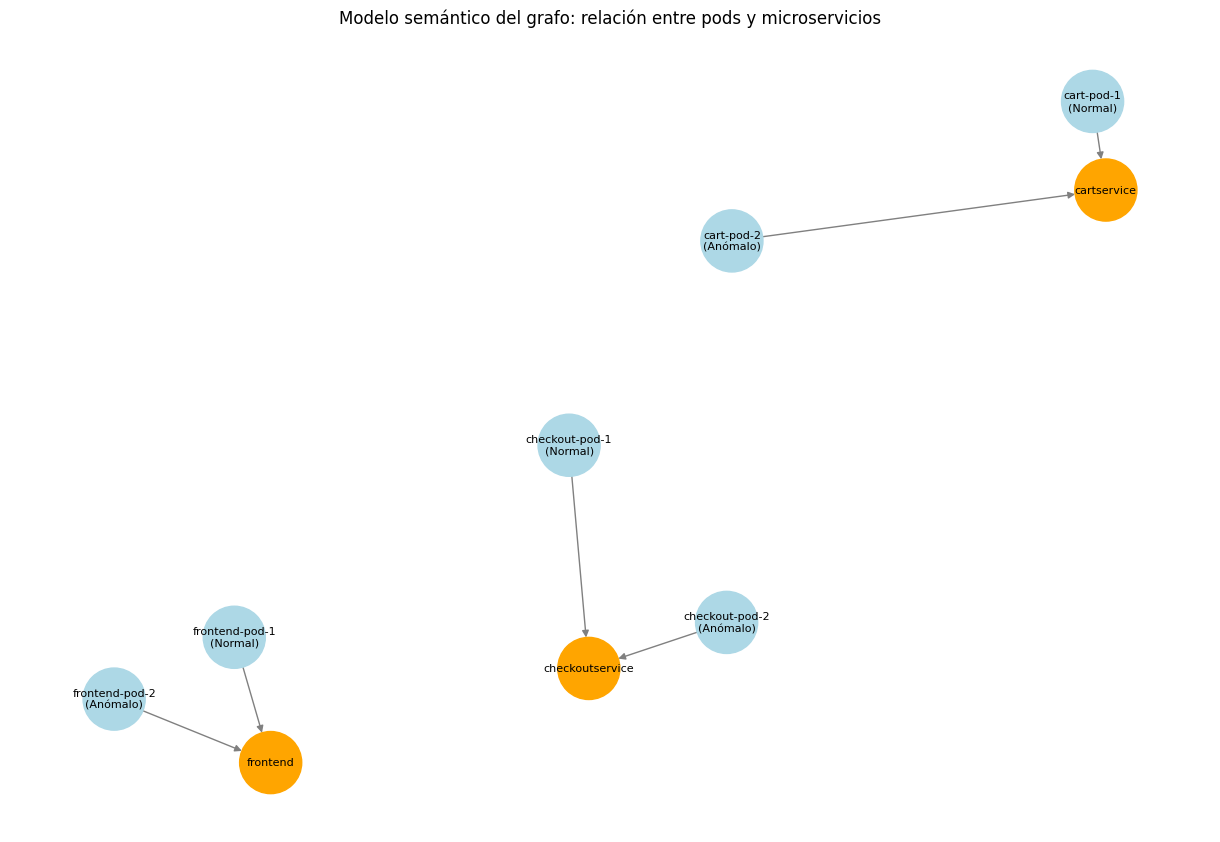

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo de ejemplo con 3 microservicios y 6 pods
G = nx.DiGraph()

# Microservicios
microservices = ["frontend", "cartservice", "checkoutservice"]
for m in microservices:
    G.add_node(m, tipo="Microservice")

# Pods (2 por microservicio)
pods = {
    "frontend-pod-1": "frontend",
    "frontend-pod-2": "frontend",
    "cart-pod-1": "cartservice",
    "cart-pod-2": "cartservice",
    "checkout-pod-1": "checkoutservice",
    "checkout-pod-2": "checkoutservice"
}

# Añadir pods y relaciones creadas
for pod, micro in pods.items():
    G.add_node(pod, tipo="Pod", label="Normal" if "1" in pod else "Anómalo")
    G.add_edge(pod, micro, relation="creado_por")

# Colores según tipo
color_map = []
for node, data in G.nodes(data=True):
    if data["tipo"] == "Microservice":
        color_map.append("orange")
    else:
        color_map.append("lightblue")

# Etiquetas con anomalía
labels = {}
for node, data in G.nodes(data=True):
    if data["tipo"] == "Pod":
        labels[node] = f"{node}\n({data['label']})"
    else:
        labels[node] = node

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=2)
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=2000, edge_color="gray")
nx.draw_networkx_labels(G, pos, labels, font_size=8)
plt.title("Modelo semántico del grafo: relación entre pods y microservicios")
plt.tight_layout()
plt.savefig("modelo_semantico_pod_microservice.png", dpi=300)
plt.show()



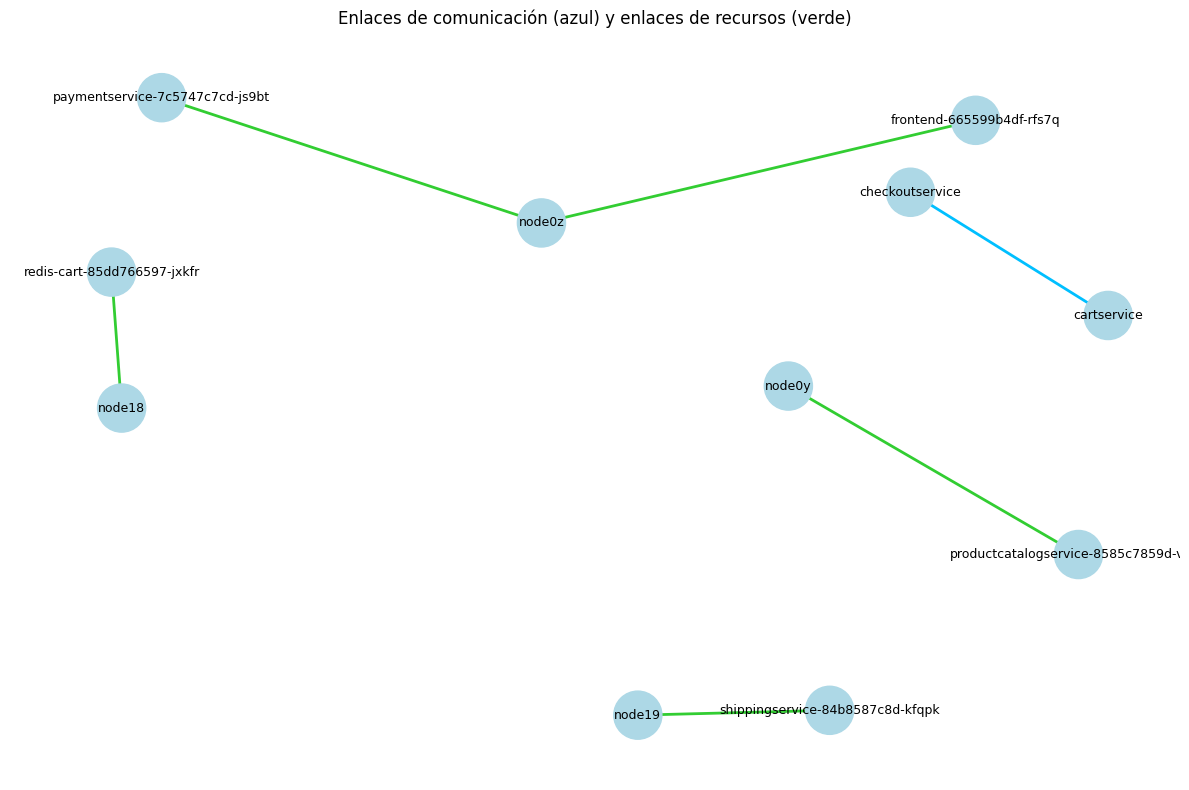

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Cargar los datos
pods_df = pd.read_csv("results/final2_modified_sorted.csv")
kiali_df = pd.read_csv("results/kiali_kpi_metrics_processed.csv")

# --- Subgrafo de comunicación (azul claro) ---
comm_edges = kiali_df.head(5)[["source_workload", "destination_workload"]].values.tolist()
comm_nodes = set([n for edge in comm_edges for n in edge])

# --- Subgrafo de recursos (verde claro) ---
resource_edges = pods_df.head(5)[["instance", "pod"]].values.tolist()
resource_nodes = set([n for edge in resource_edges for n in edge])

# Crear grafo combinado
G = nx.DiGraph()
G.add_edges_from(comm_edges, tipo="comunicacion")
G.add_edges_from(resource_edges, tipo="resource")

# Asignar colores
color_map = []
for node in G.nodes():
    if node in comm_nodes and node in resource_nodes:
        color_map.append("violet")  # Si está en ambos, púrpura
    elif node in comm_nodes:
        color_map.append("lightblue")
    elif node in resource_nodes:
        color_map.append("lightblue")
    else:
        color_map.append("gray")

# Etiquetas
labels = {node: node for node in G.nodes()}

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.7)
# Dibujar aristas de comunicación en azul y de recursos en verde
comm_edges_list = [(u, v) for u, v, d in G.edges(data=True) if d["tipo"] == "comunicacion"]
resource_edges_list = [(u, v) for u, v, d in G.edges(data=True) if d["tipo"] == "resource"]
nx.draw_networkx_edges(G, pos, edgelist=comm_edges_list, edge_color="deepskyblue", width=2, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=resource_edges_list, edge_color="limegreen", width=2, arrows=True)
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=1200)
nx.draw_networkx_labels(G, pos, labels, font_size=9)
plt.title("Enlaces de comunicación (azul) y enlaces de recursos (verde)")
plt.axis('off')
plt.tight_layout()
plt.show()

# 3.3.2

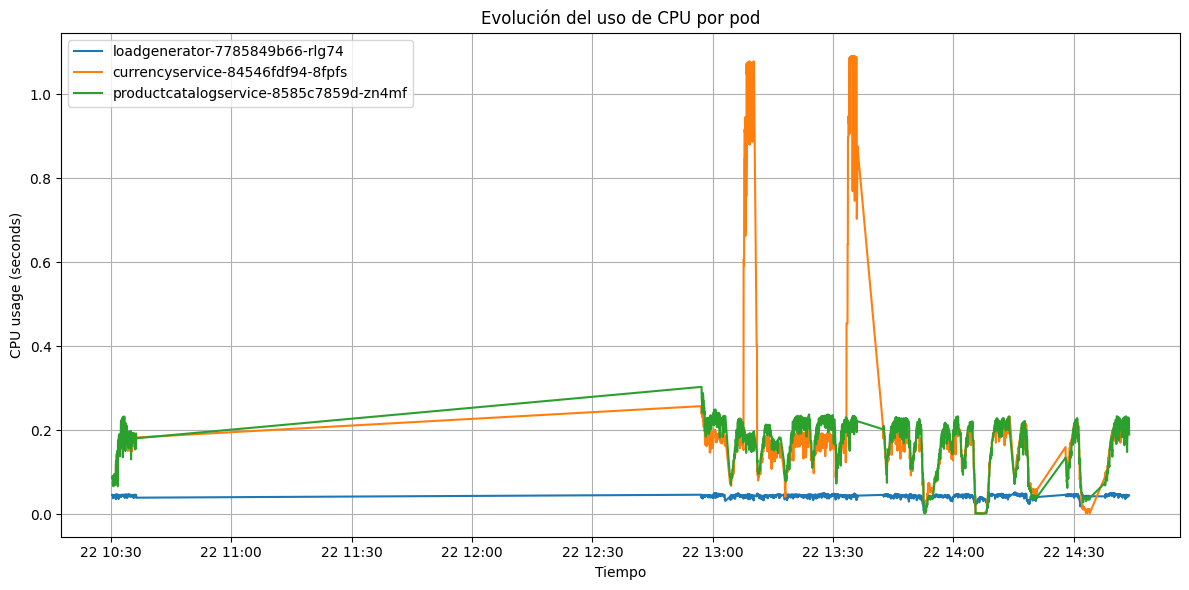

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset y asegurar orden por tiempo
df = pd.read_csv("results/final2_modified_sorted.csv", parse_dates=["timestamp"])
df.sort_values("timestamp", inplace=True)

# Selecciona los 3 pods más representados
top_pods = df["pod"].value_counts().head(3).index.tolist()
df_top = df[df["pod"].isin(top_pods)]

plt.figure(figsize=(12, 6))
for pod in top_pods:
    pod_df = df_top[df_top["pod"] == pod]
    plt.plot(pod_df["timestamp"], pod_df["container_cpu_usage_seconds_total"], label=pod)
plt.title("Evolución del uso de CPU por pod")
plt.xlabel("Tiempo")
plt.ylabel("CPU usage (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cpu_por_pod.png", dpi=200)
plt.show()


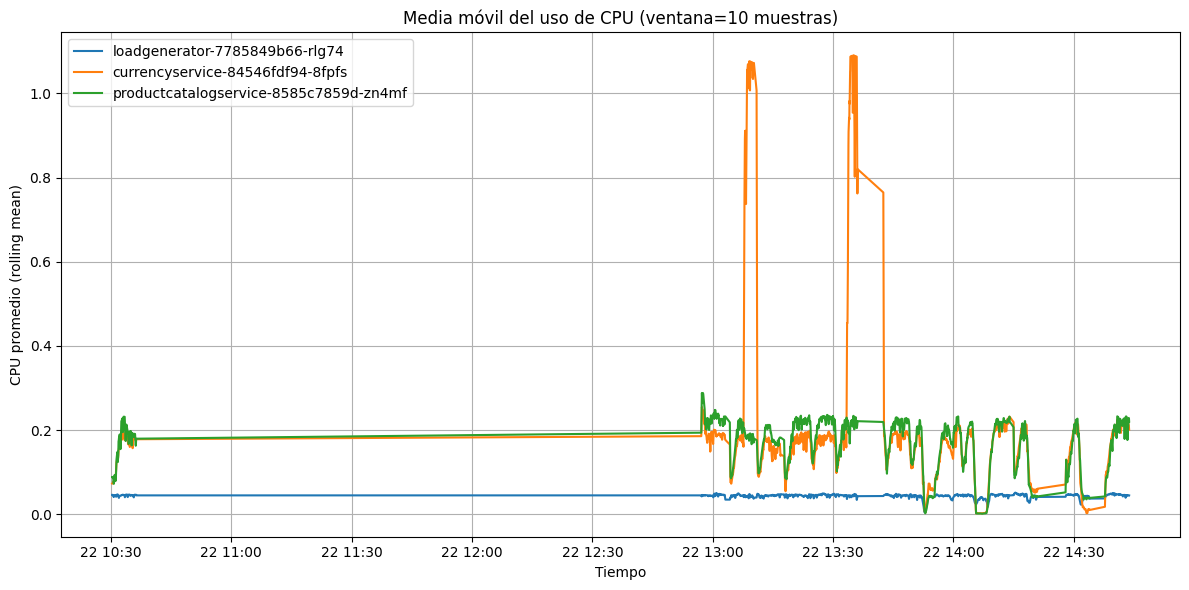

In [5]:
plt.figure(figsize=(12, 6))
window = 10  # ventana en puntos (ajusta según densidad temporal)
for pod in top_pods:
    pod_df = df_top[df_top["pod"] == pod].set_index("timestamp").sort_index()
    rolling_cpu = pod_df["container_cpu_usage_seconds_total"].rolling(window=window, min_periods=1).mean()
    plt.plot(rolling_cpu.index, rolling_cpu, label=pod)
plt.title("Media móvil del uso de CPU (ventana=10 muestras)")
plt.xlabel("Tiempo")
plt.ylabel("CPU promedio (rolling mean)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rolling_cpu_por_pod.png", dpi=200)
plt.show()


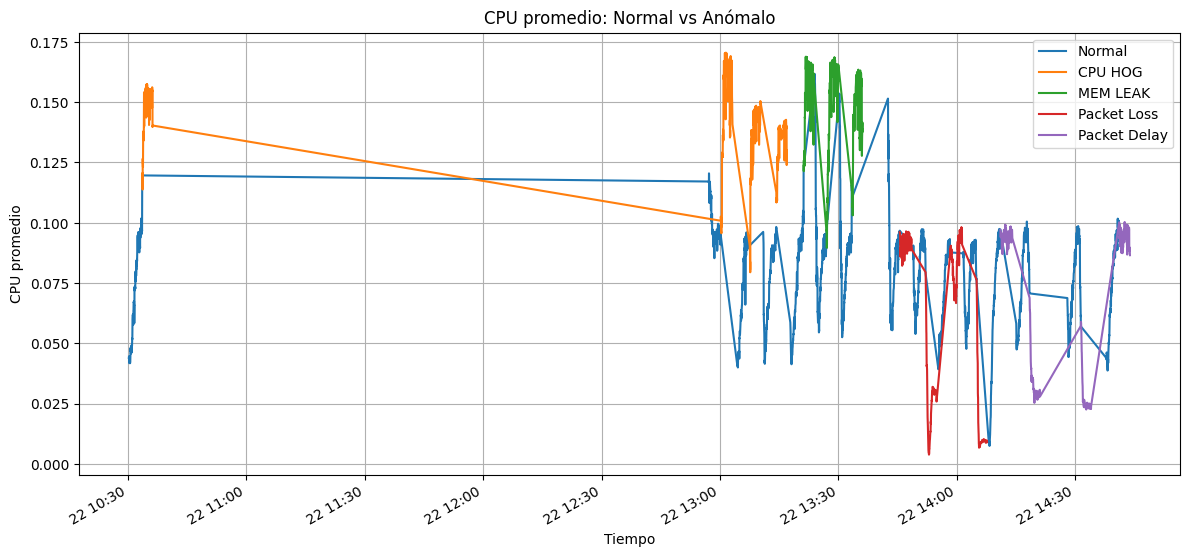

In [6]:
start_time = pd.Timestamp("2025-04-21 22:00:00")
df_filtrado = df[df["timestamp"] >= start_time]

plt.figure(figsize=(12, 6))
for clase in df_filtrado["Abnormality class"].unique():
    clase_df = df_filtrado[df_filtrado["Abnormality class"] == clase]
    avg_cpu = clase_df.groupby("timestamp")["container_cpu_usage_seconds_total"].mean()
    plt.plot(avg_cpu.index, avg_cpu, label=clase)
plt.title("CPU promedio: Normal vs Anómalo")
plt.xlabel("Tiempo")
plt.ylabel("CPU promedio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.savefig("cpu_normal_vs_anomalo.png", dpi=200)
plt.show()


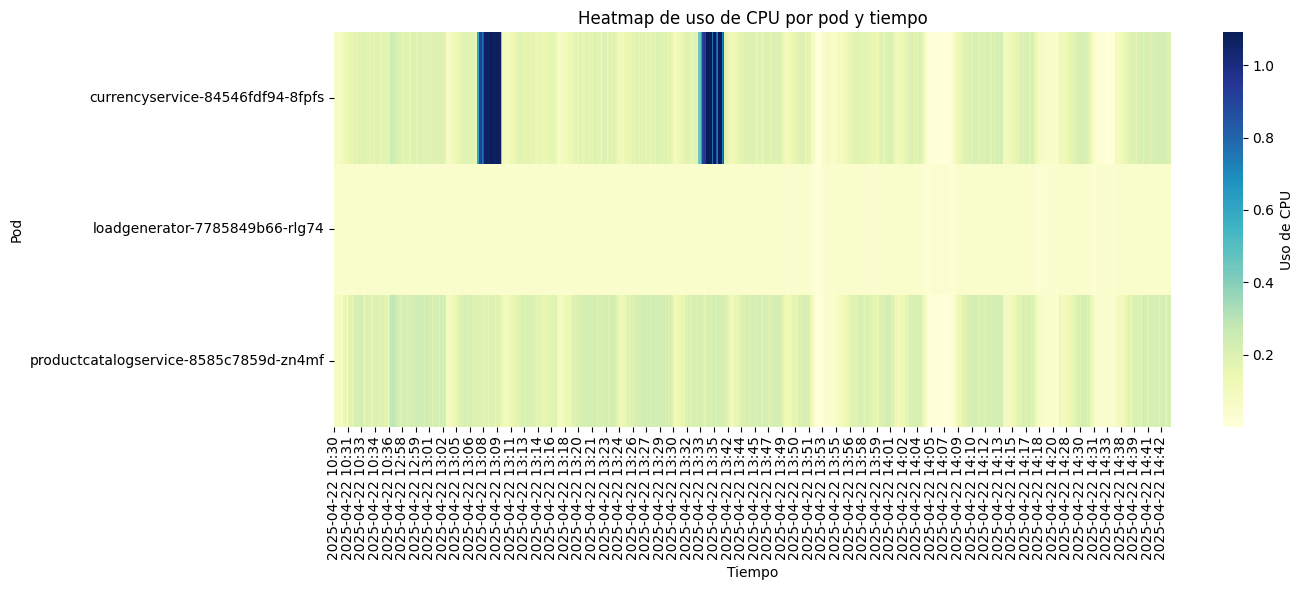

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que df_top ya está definido y cargado
# Creamos la tabla pivote
pivot_df = df_top.pivot_table(index="pod", columns="timestamp", values="container_cpu_usage_seconds_total")
pivot_df = pivot_df.fillna(0)

# Formatea las columnas (timestamps) como strings sin segundos
pivot_df.columns = [ts.strftime("%Y-%m-%d %H:%M") for ts in pivot_df.columns]

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_df, cmap="YlGnBu", cbar_kws={'label': 'Uso de CPU'})
plt.title("Heatmap de uso de CPU por pod y tiempo")
plt.xlabel("Tiempo")
plt.ylabel("Pod")
plt.tight_layout()
plt.savefig("heatmap_cpu_pods.png", dpi=200)
plt.show()


Abnormality class
Normal          56401
Packet Delay    11811
Packet Loss      9688
CPU HOG          9562
MEM LEAK         7462
Name: count, dtype: int64


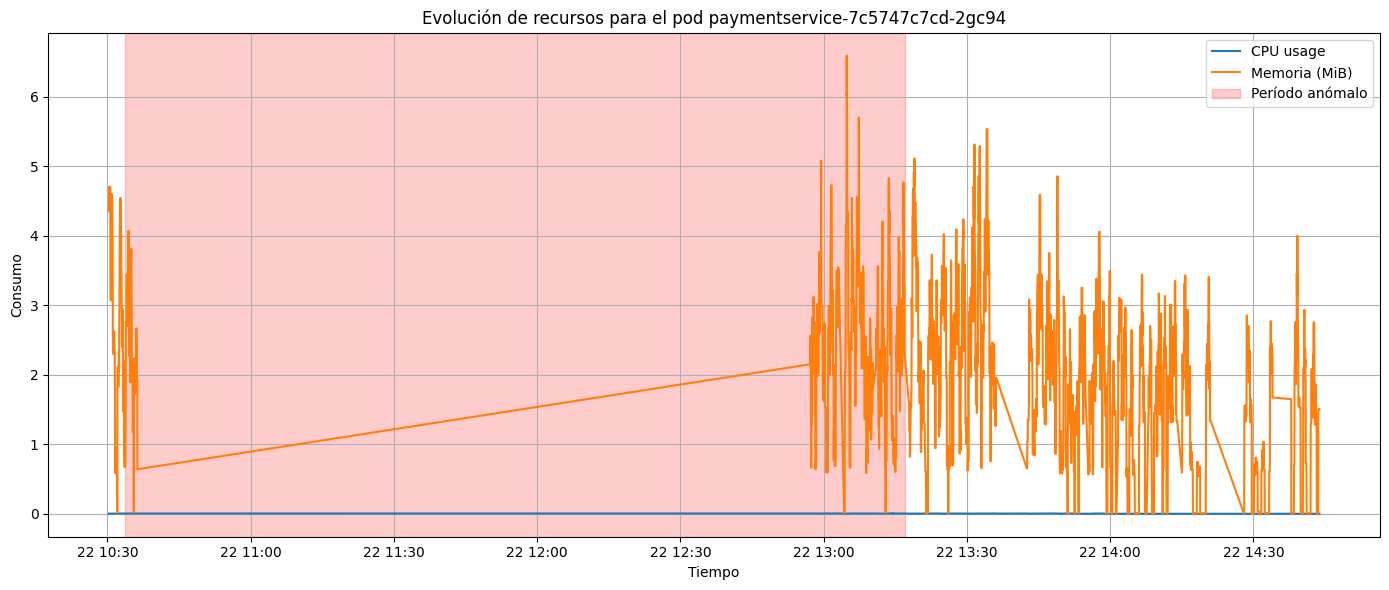

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("results/final2_modified_sorted.csv", parse_dates=["timestamp"])

# Buscar los tipos de anomalía presentes
print(df["Abnormality class"].value_counts())

# Elegimos un pod que haya experimentado, por ejemplo, 'CPU HOG'
pod_cpu_hog = df[df["Abnormality class"] == "CPU HOG"]["pod"].value_counts().idxmax()

# Filtramos ese pod
df_pod = df[df["pod"] == pod_cpu_hog].sort_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(df_pod["timestamp"], df_pod["container_cpu_usage_seconds_total"], label="CPU usage")
plt.plot(df_pod["timestamp"], df_pod["container_memory_working_set_bytes"]/1024**2, label="Memoria (MiB)")
plt.axvspan(
    df_pod[df_pod["Abnormality class"] == "CPU HOG"]["timestamp"].min(),
    df_pod[df_pod["Abnormality class"] == "CPU HOG"]["timestamp"].max(),
    color='red', alpha=0.2, label="Período anómalo"
)
plt.title(f"Evolución de recursos para el pod {pod_cpu_hog}")
plt.xlabel("Tiempo")
plt.ylabel("Consumo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("detalle_temporal_anomalia.png", dpi=200)
plt.show()


Observaciones clave
Comportamiento previo a la anomalía:

La memoria y la CPU muestran valores bajos y relativamente estables, especialmente la CPU (azul), que se mantiene cerca de cero la mayor parte del tiempo.

Durante la anomalía (zona roja):

Se observa un aumento progresivo en el uso de memoria, con valores que llegan a superar los 6 MiB en algunos instantes.

La CPU, sin embargo, se mantiene casi constante y baja; no parece haber un pico significativo en este recurso, lo que sugiere que la anomalía en este caso afecta fundamentalmente a la memoria.

Después de la anomalía:

El uso de memoria continúa con valores elevados y alta variabilidad (fluctuaciones notables).

La CPU permanece estable y baja, sin variaciones significativas.

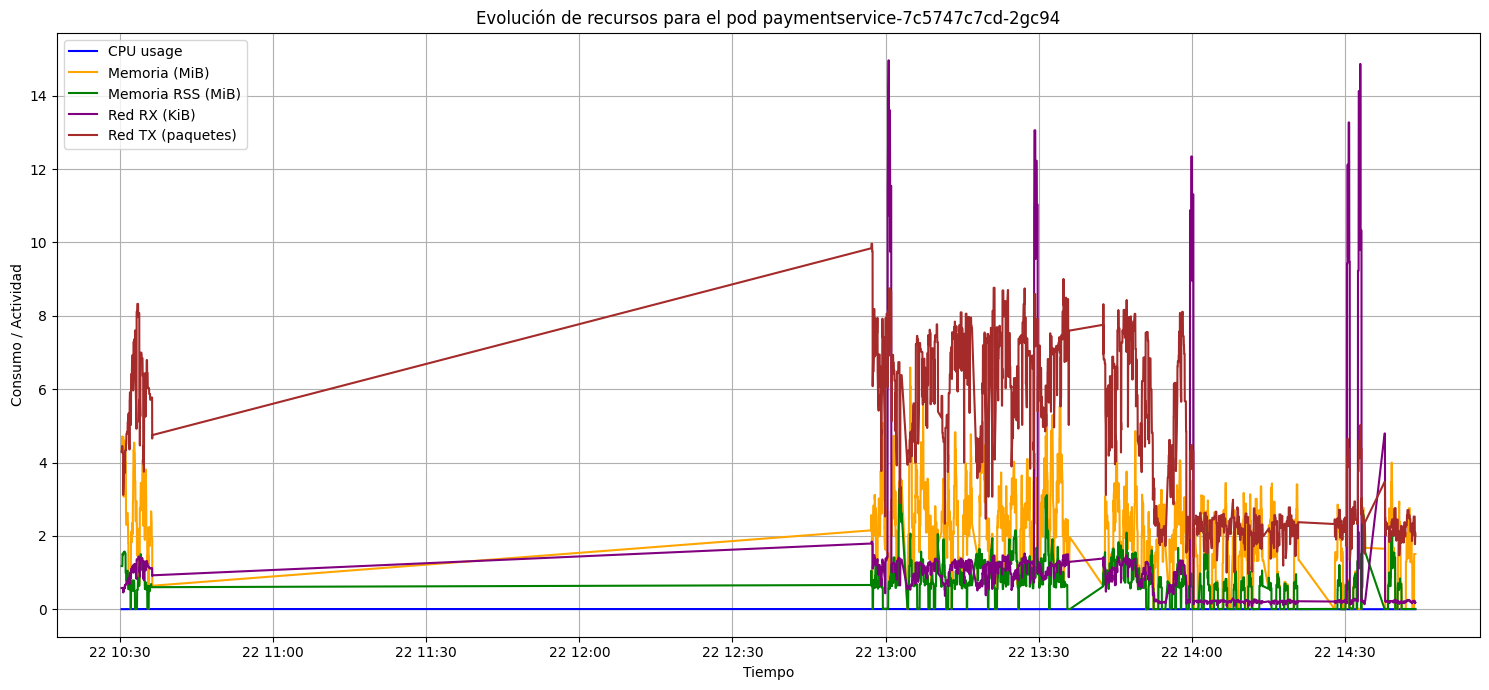

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv("results/final2_modified_sorted.csv", parse_dates=["timestamp"])

# Seleccionar el pod concreto (puedes cambiar el nombre por el que prefieras)
pod_id = "paymentservice-7c5747c7cd-2gc94"
df_pod = df[df["pod"] == pod_id].sort_values("timestamp")

# # Buscar intervalo anómalo
# anom_mask = (df_pod["Abnormality class"] != 1) & (df_pod["Abnormality class"] != "Normal")
# if anom_mask.any():
#     start_anom = df_pod[anom_mask]["timestamp"].min()
#     end_anom = df_pod[anom_mask]["timestamp"].max()
# else:
#     start_anom = end_anom = None

plt.figure(figsize=(15, 7))

# Métricas principales
plt.plot(df_pod["timestamp"], df_pod["container_cpu_usage_seconds_total"], label="CPU usage", color="blue")
plt.plot(df_pod["timestamp"], df_pod["container_memory_working_set_bytes"] / 1024**2, label="Memoria (MiB)", color="orange")
plt.plot(df_pod["timestamp"], df_pod["container_memory_rss"] / 1024**2, label="Memoria RSS (MiB)", color="green")
plt.plot(df_pod["timestamp"], df_pod["container_network_receive_bytes_total"] / 1024, label="Red RX (KiB)", color="purple")
plt.plot(df_pod["timestamp"], df_pod["container_network_transmit_packets_total"], label="Red TX (paquetes)", color="brown")

# if start_anom and end_anom:
    # plt.axvspan(start_anom, end_anom, color="red", alpha=0.15, label="Período anómalo")
# plt.axvspan(
#     df_pod[df_pod["Abnormality class"] != "Normal"]["timestamp"].min(),
#     df_pod[df_pod["Abnormality class"] != "Normal"]["timestamp"].max(),
#     color='red', alpha=0.2, label="Período anómalo"
# )

plt.title(f"Evolución de recursos para el pod {pod_id}")
plt.xlabel("Tiempo")
plt.ylabel("Consumo / Actividad")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.savefig("evolucion_recursos_pod_multimetrica.png", dpi=200)
plt.show()


Observaciones clave
Antes de la anomalía:

Todos los recursos permanecen en valores bajos y estables.

El tráfico de red y los paquetes transmitidos tienen poca actividad.

Durante la anomalía:

Memoria activa (naranja) y RSS (verde) presentan una subida considerable y con alta variabilidad, reflejando una posible fuga de memoria o sobrecarga en el pod.

Red RX (morado) y TX (marrón) muestran picos y oscilaciones, lo que indica un aumento de actividad en la red durante el fallo.

CPU (azul), sin embargo, permanece prácticamente constante y en valores bajos, lo que descarta un consumo excesivo de CPU como raíz del problema en este caso.

Después de la anomalía:

Los valores de memoria y red siguen mostrando cierta variabilidad, pero tienden a reducirse gradualmente, sugiriendo una vuelta progresiva a la normalidad, aunque con fluctuaciones residuales.

In [10]:
import seaborn as sns

tabla = pd.crosstab(df["Microservice"], df["anom_label"])
plt.figure(figsize=(10, 6))
sns.heatmap(tabla, annot=True, fmt="d", cmap="Reds")
plt.title("Incidencia de anomalías por microservicio")
plt.xlabel("Tipo de anomalía")
plt.ylabel("Microservicio")
plt.tight_layout()
plt.savefig("anomalias_por_microservicio.png", dpi=200)
plt.show()


KeyError: 'anom_label'

# 4.2

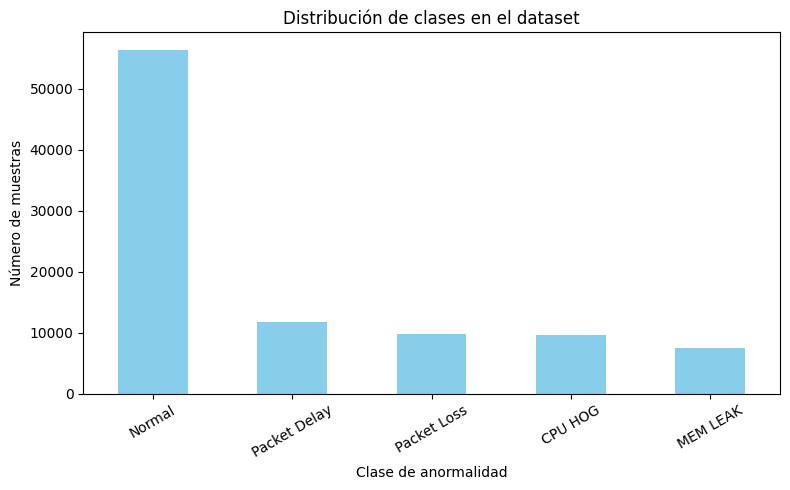

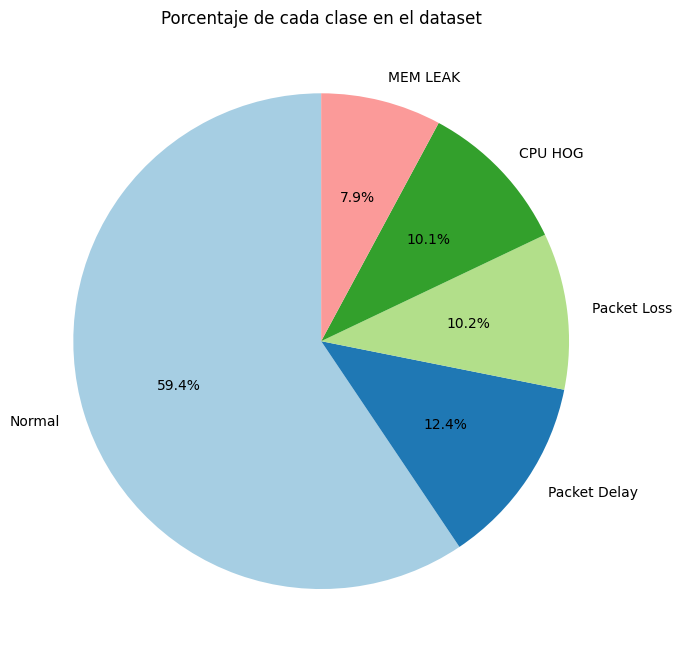

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/final2_modified_sorted.csv")

# Si la columna es numérica, pásala a string para el gráfico
if df["Abnormality class"].dtype != "O":
    df["Abnormality class"] = df["Abnormality class"].astype(str)

# Histograma de barras
plt.figure(figsize=(8, 5))
df["Abnormality class"].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribución de clases en el dataset")
plt.xlabel("Clase de anormalidad")
plt.ylabel("Número de muestras")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("histograma_abnormality_class.png", dpi=200)
plt.show()

# Si prefieres un pie chart:
plt.figure(figsize=(7, 7))
df["Abnormality class"].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Porcentaje de cada clase en el dataset")
plt.ylabel("")
plt.tight_layout()
plt.savefig("pie_abnormality_class.png", dpi=200)
plt.show()


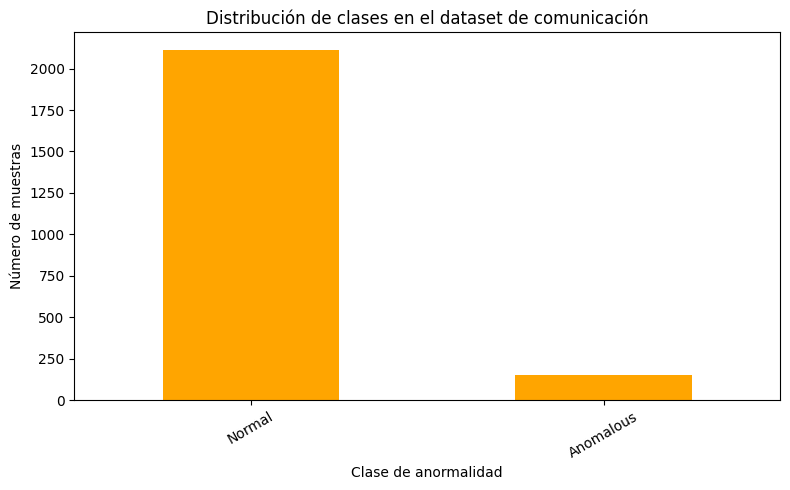

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_comm = pd.read_csv("results/kiali_kpi_metrics_processed.csv")

# Si es numérica, pásala a string para el gráfico
if df_comm["Abnormality class"].dtype != "O":
    df_comm["Abnormality class"] = df_comm["Abnormality class"].astype(str)

plt.figure(figsize=(8, 5))
df_comm["Abnormality class"].value_counts().plot(kind='bar', color='orange')
plt.title("Distribución de clases en el dataset de comunicación")
plt.xlabel("Clase de anormalidad")
plt.ylabel("Número de muestras")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("histograma_abnormality_class_comm.png", dpi=200)
plt.show()


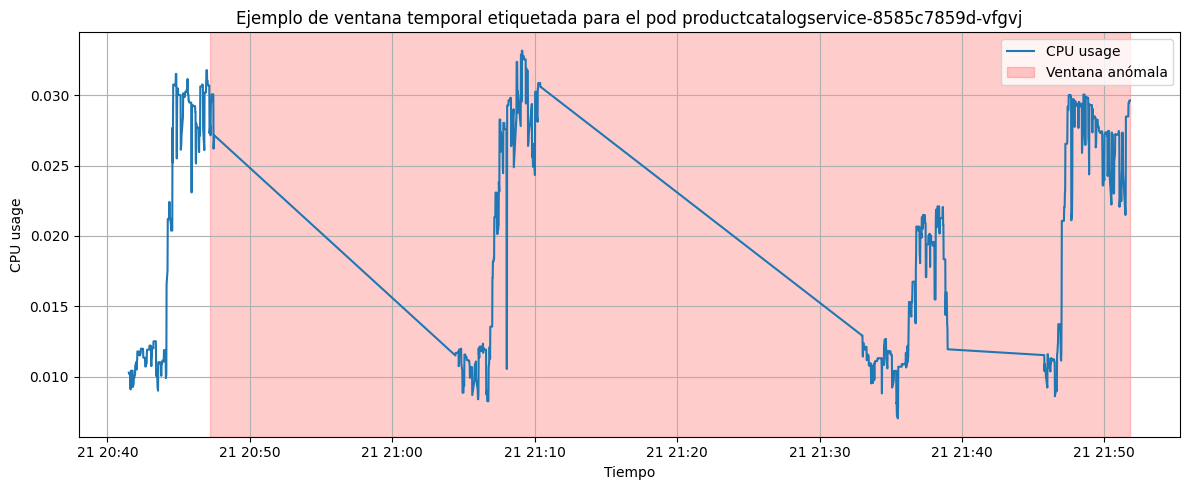

In [ ]:
# Selecciona un pod con anomalías
pod_id = df[df["Abnormality class"] != "Normal"]["pod"].iloc[0]
df_pod = df[df["pod"] == pod_id].sort_values("timestamp")
df_pod["timestamp"] = pd.to_datetime(df_pod["timestamp"])

plt.figure(figsize=(12, 5))
plt.plot(df_pod["timestamp"], df_pod["container_cpu_usage_seconds_total"], label="CPU usage")
anom_mask = df_pod["Abnormality class"] != "Normal"
if anom_mask.any():
    plt.axvspan(df_pod[anom_mask]["timestamp"].min(), df_pod[anom_mask]["timestamp"].max(), color='red', alpha=0.2, label="Ventana anómala")
plt.title(f"Ejemplo de ventana temporal etiquetada para el pod {pod_id}")
plt.xlabel("Tiempo")
plt.ylabel("CPU usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ejemplo_ventana_etiquetado.png", dpi=200)
plt.show()


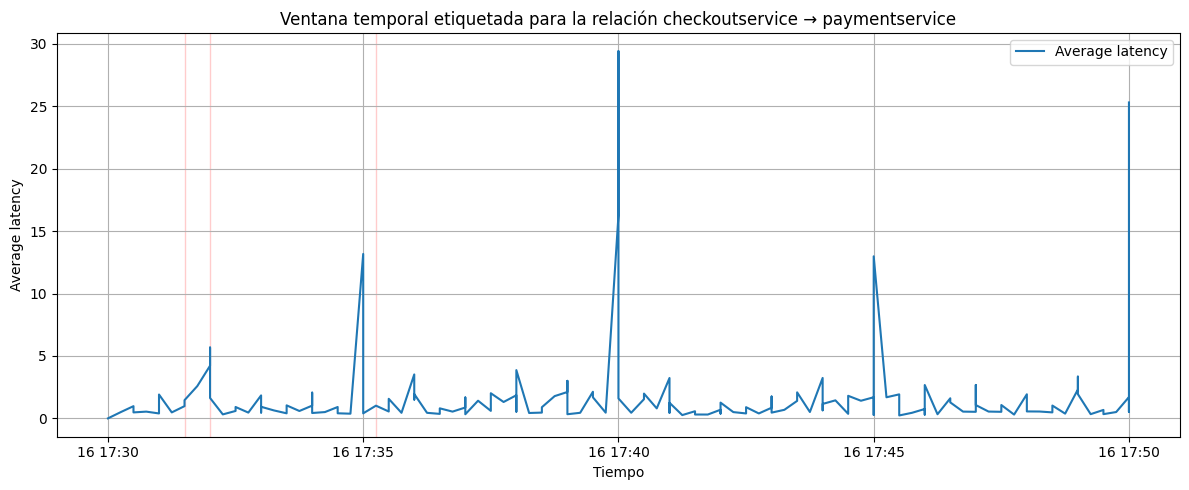

In [ ]:
# Selecciona una relación (source → destination) con anomalías
rel = df_comm[df_comm["Abnormality class"] != "Normal"][["source_workload", "destination_workload"]].iloc[0]
src, dst = rel["source_workload"], rel["destination_workload"]
df_pair = df_comm[(df_comm["source_workload"] == src) & (df_comm["destination_workload"] == dst)].sort_values("timestamp")
df_pair["timestamp"] = pd.to_datetime(df_pair["timestamp"])

plt.figure(figsize=(12, 5))
plt.plot(df_pair["timestamp"], df_pair["average_latency"], label="Average latency")

# Identifica todos los periodos anómalos (pueden ser discontinuos)
anom_mask = df_pair["Abnormality class"] != "Normal"
if anom_mask.any():
    # Encuentra los inicios y finales de cada segmento anómalo
    anom_indices = df_pair.index[anom_mask]
    # Detecta saltos entre índices para separar segmentos
    splits = anom_indices.to_series().diff().ne(1).cumsum()
    for _, group in df_pair.loc[anom_indices].groupby(splits):
        plt.axvspan(group["timestamp"].min(), group["timestamp"].max(), color='red', alpha=0.2)

plt.title(f"Ventana temporal etiquetada para la relación {src} → {dst}")
plt.xlabel("Tiempo")
plt.ylabel("Average latency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ejemplo_ventana_etiquetado_comm.png", dpi=200)
plt.show()


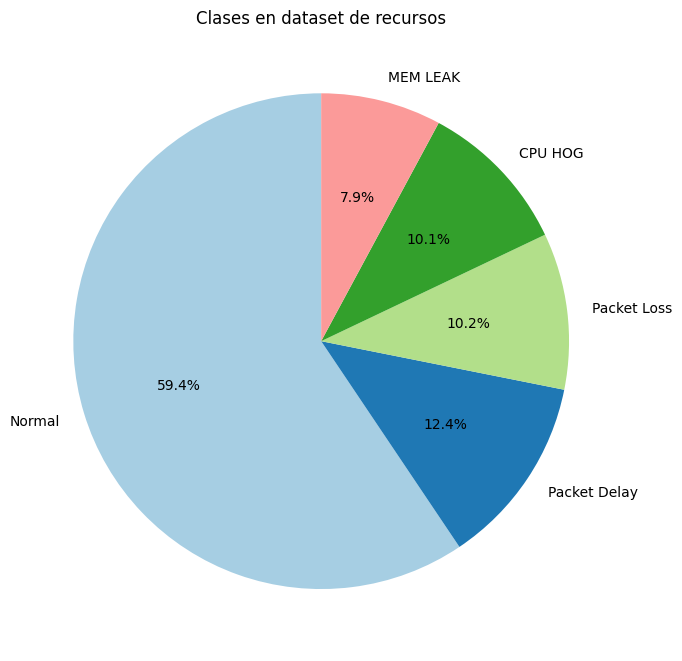

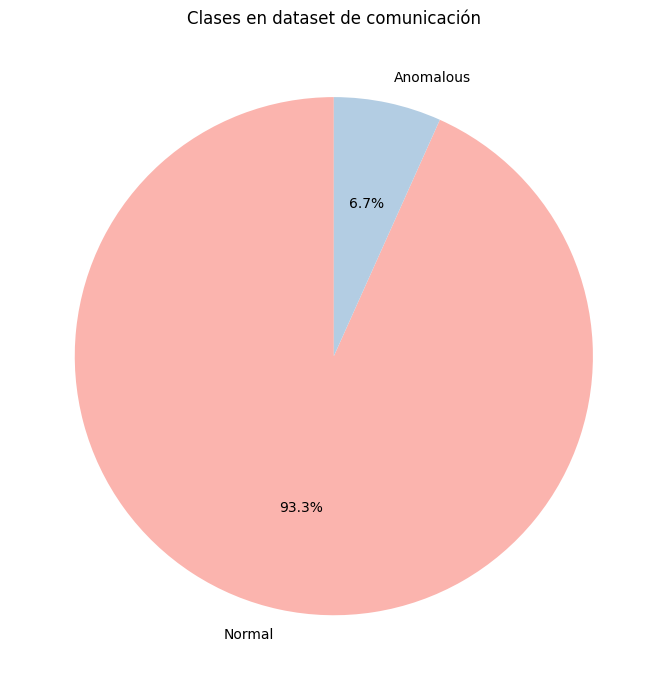

In [ ]:
# Recursos
plt.figure(figsize=(7, 7))
df["Abnormality class"].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Clases en dataset de recursos")
plt.ylabel("")
plt.tight_layout()
plt.savefig("pie_abnormality_recursos.png", dpi=200)
plt.show()

# Comunicación
plt.figure(figsize=(7, 7))
df_comm["Abnormality class"].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title("Clases en dataset de comunicación")
plt.ylabel("")
plt.tight_layout()
plt.savefig("pie_abnormality_communication.png", dpi=200)
plt.show()


# 4.3

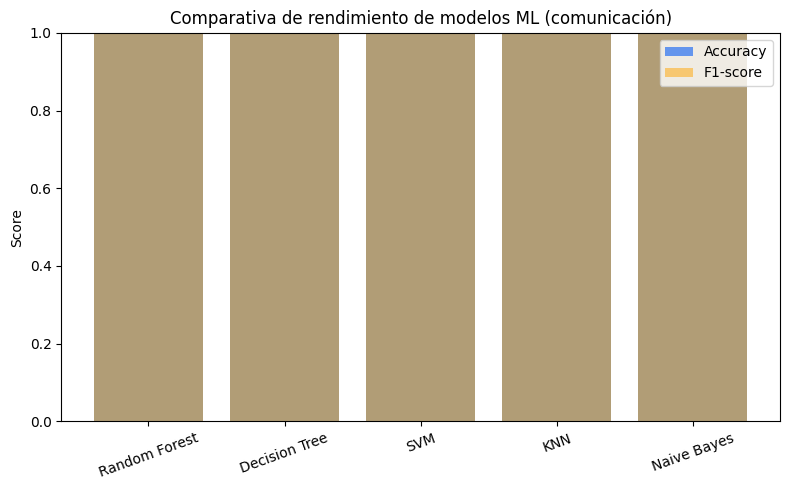

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Cargar datos de comunicación
df = pd.read_csv("results/kiali_kpi_metrics_processed.csv")

# Preprocesado simple
X = df.drop(columns=["Abnormality class", "timestamp", "source_workload", "destination_workload", "protocol", "Experiment"], errors="ignore")
y = df["Abnormality class"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))
X.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

accuracies = {}
f1_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)
    f1_scores[name] = f1_score(y_test, y_pred, average="weighted")

plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color="cornflowerblue", label="Accuracy")
plt.bar(f1_scores.keys(), f1_scores.values(), color="orange", alpha=0.5, label="F1-score")
plt.title("Comparativa de rendimiento de modelos ML (comunicación)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.legend()
plt.tight_layout()
plt.savefig("ml_comparison_comm.png", dpi=200)
plt.show()


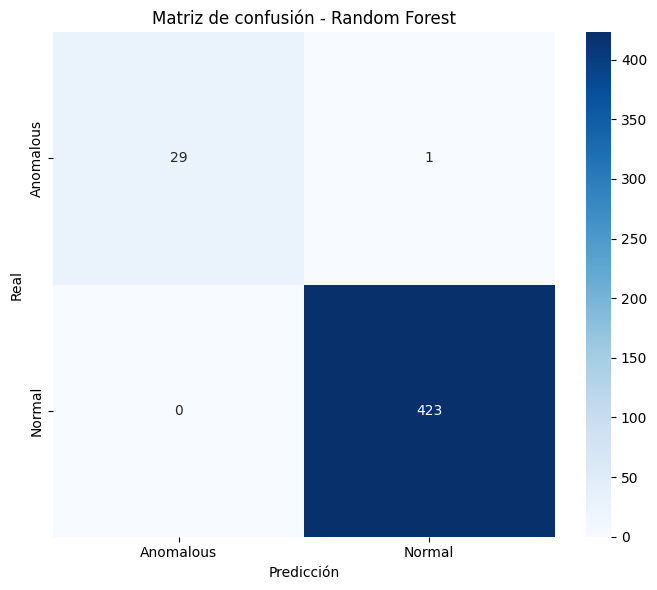

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Elige el mejor modelo (por ejemplo, Random Forest)
best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("confusion_matrix_rf_comm.png", dpi=200)
plt.show()
